In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data_file = "./lung+cancer/lung-cancer.data"
column_names = ["class"] + [f"Attribute{i}" for i in range(1, 57)]
df = pd.read_csv(data_file, header=None, names=column_names, na_values=["?"])

# Separate features and target
X = df.iloc[:, 1:]  # All columns except the first (features)
y = df.iloc[:, 0]   # First column (target)
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute47,Attribute48,Attribute49,Attribute50,Attribute51,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56
0,0,3,0,NaN,0,2,2,2,1,1,...,2,2,2,2,2,1,1,1,2,2
1,0,3,3,1.0,0,3,1,3,1,1,...,2,2,2,2,2,2,2,1,2,2
2,0,3,3,2.0,0,3,3,3,1,1,...,2,2,2,2,2,2,2,2,1,2
3,0,2,3,2.0,1,3,3,3,1,2,...,2,2,2,2,2,2,2,2,2,2
4,0,3,2,1.0,1,3,3,3,2,2,...,2,2,2,2,2,2,2,1,2,2


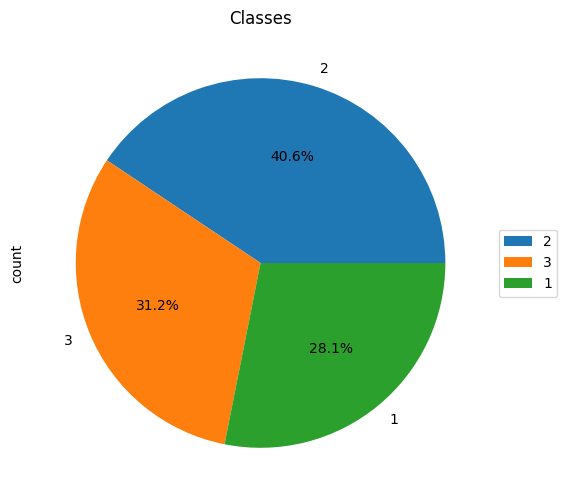

In [3]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

# Plot the pie chart
y.value_counts().plot(kind="pie", autopct="%.1f%%", ax=ax)

# Set the title
plt.title("Classes")

# Relocate the legend to the right of the pie chart
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [4]:
print(X.duplicated())

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
dtype: bool


In [5]:
# Check for missing values
print("\nPercentage of missing values in Features:")
print(X.isnull().sum()/X.shape[0]*100)
# Fill missing values with the mode for each column
X = X.fillna(X.mode().iloc[0])


Percentage of missing values in Features:
Attribute1      0.000
Attribute2      0.000
Attribute3      0.000
Attribute4     12.500
Attribute5      0.000
Attribute6      0.000
Attribute7      0.000
Attribute8      0.000
Attribute9      0.000
Attribute10     0.000
Attribute11     0.000
Attribute12     0.000
Attribute13     0.000
Attribute14     0.000
Attribute15     0.000
Attribute16     0.000
Attribute17     0.000
Attribute18     0.000
Attribute19     0.000
Attribute20     0.000
Attribute21     0.000
Attribute22     0.000
Attribute23     0.000
Attribute24     0.000
Attribute25     0.000
Attribute26     0.000
Attribute27     0.000
Attribute28     0.000
Attribute29     0.000
Attribute30     0.000
Attribute31     0.000
Attribute32     0.000
Attribute33     0.000
Attribute34     0.000
Attribute35     0.000
Attribute36     0.000
Attribute37     0.000
Attribute38     3.125
Attribute39     0.000
Attribute40     0.000
Attribute41     0.000
Attribute42     0.000
Attribute43     0.000
Attribute44

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Adjust class labels to start from 0
y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

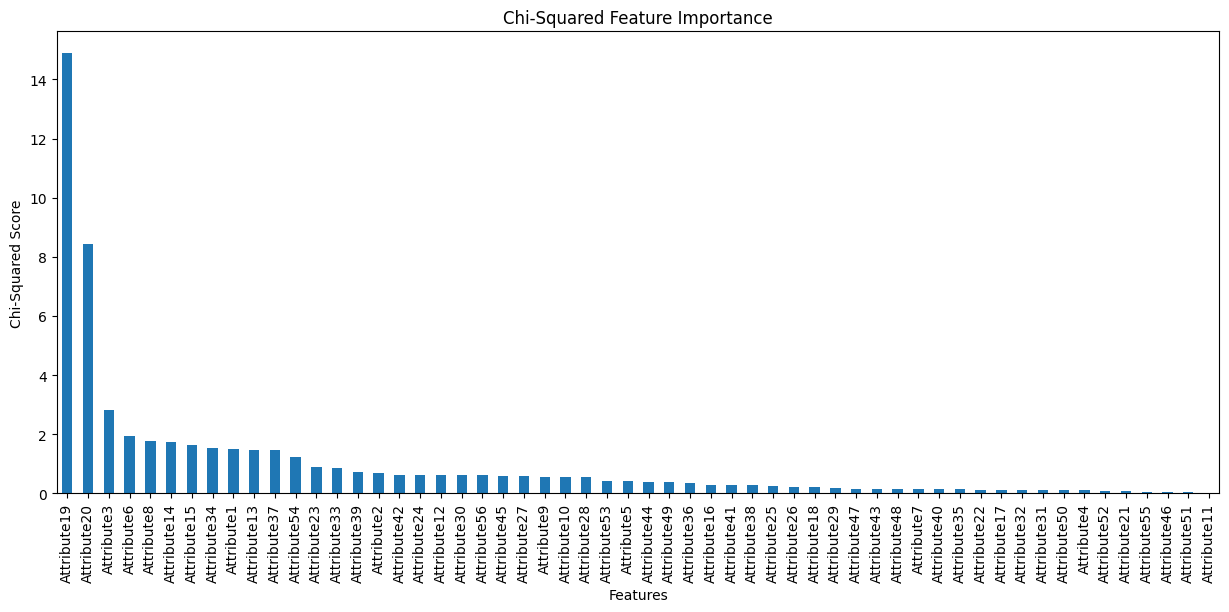

In [7]:
from sklearn.feature_selection import SelectKBest, chi2
chi_scores = chi2(X_train, y_train)
chi_scores
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
# Set the figure size
plt.figure(figsize=(15, 6))  # Adjust width (15) and height (6) as needed
chi_values.plot.bar()

# Add labels and title
plt.xlabel("Features")
plt.ylabel("Chi-Squared Score")
plt.title("Chi-Squared Feature Importance")
plt.show()

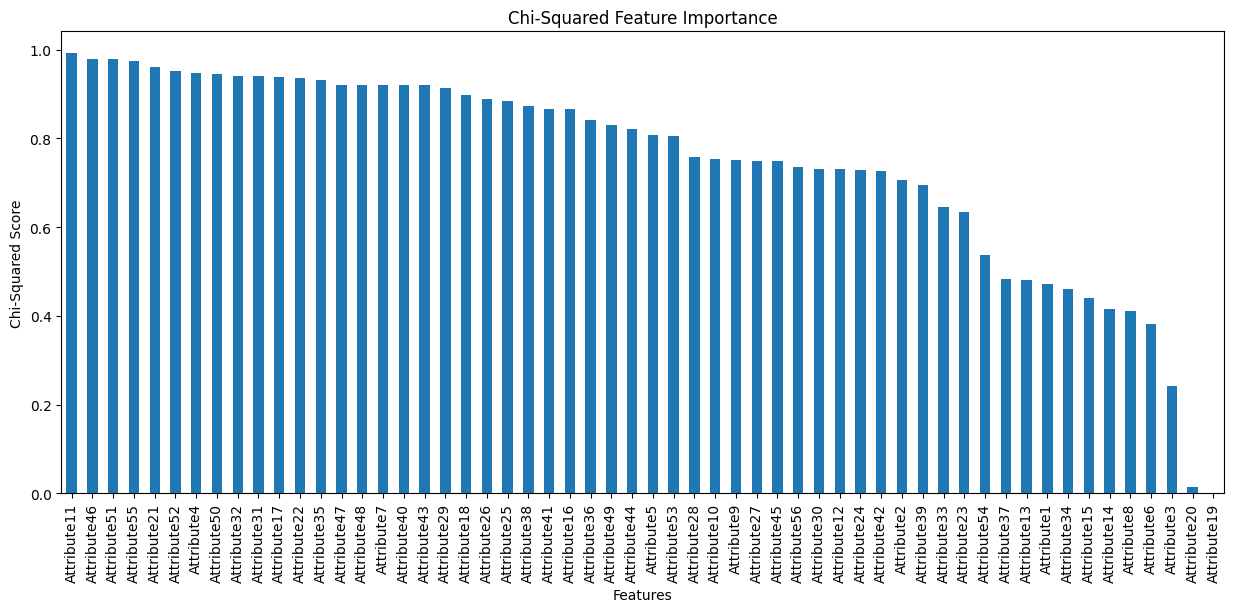

In [8]:
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=False, inplace=True)
# Set the figure size
plt.figure(figsize=(15, 6))  # Adjust width (15) and height (6) as needed
p_values.plot.bar()

# Add labels and title
plt.xlabel("Features")
plt.ylabel("p-value Score")
plt.title("p-value")
plt.show()

In [49]:
# Define feature selection and encoding steps
feature_selector = SelectKBest(score_func=chi2, k=5)
# handle unknown categories
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Function to create a pipeline
def create_pipeline(model):
    return Pipeline(steps=[
        ('feature_selection', feature_selector),
        ('onehot_encoding', encoder),
        ('classifier', model)
    ])

In [17]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(
        penalty='l2', solver='saga', class_weight='balanced', max_iter=1000,
        multi_class='multinomial', n_jobs=-1, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=40, max_depth=5, n_jobs=-1, random_state=42,
        class_weight='balanced_subsample'
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss', random_state=42
    ),
    "Support Vector Classification": SVC(
        class_weight='balanced', C=1, gamma=0.1, kernel='rbf', random_state=42
    )
}

In [34]:
import warnings
warnings.filterwarnings("ignore")
# Evaluate models using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    results[model_name] = (scores.mean(), scores.std())

# Display results
print("Cross-Validation Results:")
for model_name, (mean_acc, std_acc) in results.items():
    print(f"{model_name}: Mean Accuracy = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")

Cross-Validation Results:
Logistic Regression: Mean Accuracy = 0.5600, Std Dev = 0.1960
Random Forest: Mean Accuracy = 0.5200, Std Dev = 0.1600
XGBoost: Mean Accuracy = 0.5600, Std Dev = 0.1960
Support Vector Classification: Mean Accuracy = 0.5200, Std Dev = 0.2040


In [46]:
from sklearn.model_selection import GridSearchCV

# Grid Search Parameters
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__solver': ['saga', 'lbfgs'],
        'classifier__penalty': ['l1', 'l2'],
        'feature_selection__k': [2, 3, 4, 5]
    },
    "Random Forest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
        'feature_selection__k': [2, 3, 4, 5]
    },
    "XGBoost": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'feature_selection__k': [2, 3, 4, 5]
    },
    "Support Vector Classification": {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
        'classifier__kernel': ['rbf', 'linear', 'poly'],
        'feature_selection__k': [2, 3, 4, 5]
    }
}

# Results dictionary to store best parameters and scores
grid_results = {}

# Perform Grid Search for each model
for model_name, model in models.items():
    pipeline = create_pipeline(model)
    
    # Perform Grid Search
    grid_search = GridSearchCV(
        pipeline, 
        param_grids[model_name], 
        cv=skf, 
        scoring='f1_weighted', 
        n_jobs=-1
    )
    
    # Fit Grid Search
    grid_search.fit(X_train, y_train)
    
    # Store results
    grid_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Display Grid Search Results
print("Grid Search Results:")
for model_name, result in grid_results.items():
    print(f"\n{model_name}:")
    print("Best Parameters:", result['best_params'])
    print(f"Best F1 score: {result['best_score']:.4f}")


Grid Search Results:

Logistic Regression:
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'feature_selection__k': 3}
Best F1 score: 0.5387

Random Forest:
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50, 'feature_selection__k': 4}
Best F1 score: 0.6053

XGBoost:
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.6, 'feature_selection__k': 4}
Best F1 score: 0.6120

Support Vector Classification:
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'feature_selection__k': 5}
Best F1 score: 0.6133


In [47]:
# Update models with best parameters
updated_models = {
    "Logistic Regression": LogisticRegression(
        **{k.replace('classifier__', ''): v for k, v in grid_results["Logistic Regression"]['best_params'].items() if 'classifier__' in k},
        class_weight='balanced', 
        max_iter=1000,
        multi_class='multinomial', 
        n_jobs=-1, 
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        **{k.replace('classifier__', ''): v for k, v in grid_results["Random Forest"]['best_params'].items() if 'classifier__' in k},
        class_weight='balanced_subsample', 
        n_jobs=-1, 
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        **{k.replace('classifier__', ''): v for k, v in grid_results["XGBoost"]['best_params'].items() if 'classifier__' in k},
        use_label_encoder=False, 
        eval_metric='mlogloss', 
        random_state=42
    ),
    "Support Vector Classification": SVC(
        **{k.replace('classifier__', ''): v for k, v in grid_results["Support Vector Classification"]['best_params'].items() if 'classifier__' in k},
        class_weight='balanced', 
        random_state=42
    )
}

# Re-evaluate with updated models
results = {}
for model_name, model in updated_models.items():
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    results[model_name] = (scores.mean(), scores.std())

# Display final results
print("\nFinal Cross-Validation Results:")
for model_name, (mean_acc, std_acc) in results.items():
    print(f"{model_name}: Mean Accuracy = {mean_acc:.4f}, Std Dev = {std_acc:.4f}")


Final Cross-Validation Results:
Logistic Regression: Mean Accuracy = 0.5600, Std Dev = 0.1960
Random Forest: Mean Accuracy = 0.4800, Std Dev = 0.1600
XGBoost: Mean Accuracy = 0.5600, Std Dev = 0.1960
Support Vector Classification: Mean Accuracy = 0.5200, Std Dev = 0.1600


In [50]:
from sklearn.metrics import confusion_matrix
# Final model evaluation on the test set
print("\nTest Set Evaluation:")
for model_name, model in models.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate test performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Test Set Evaluation:

Logistic Regression Test Set Performance:
Accuracy: 0.7143
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.33      0.50         3
           2       0.67      1.00      0.80         2

    accuracy                           0.71         7
   macro avg       0.78      0.78      0.70         7
weighted avg       0.81      0.71      0.67         7


Random Forest Test Set Performance:
Accuracy: 0.5714
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67         2

    accuracy                           0.57         7
   macro avg       0.39      0.67      0.49         7
weighted avg       0.33      0.57      0.42         7


XGBoost Test Set Performance:
Accuracy: 0.7143
Classifi